Saving Combined VC Data - Sheet1.csv to Combined VC Data - Sheet1 (1).csv


<ipython-input-3-22eae51aedba>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


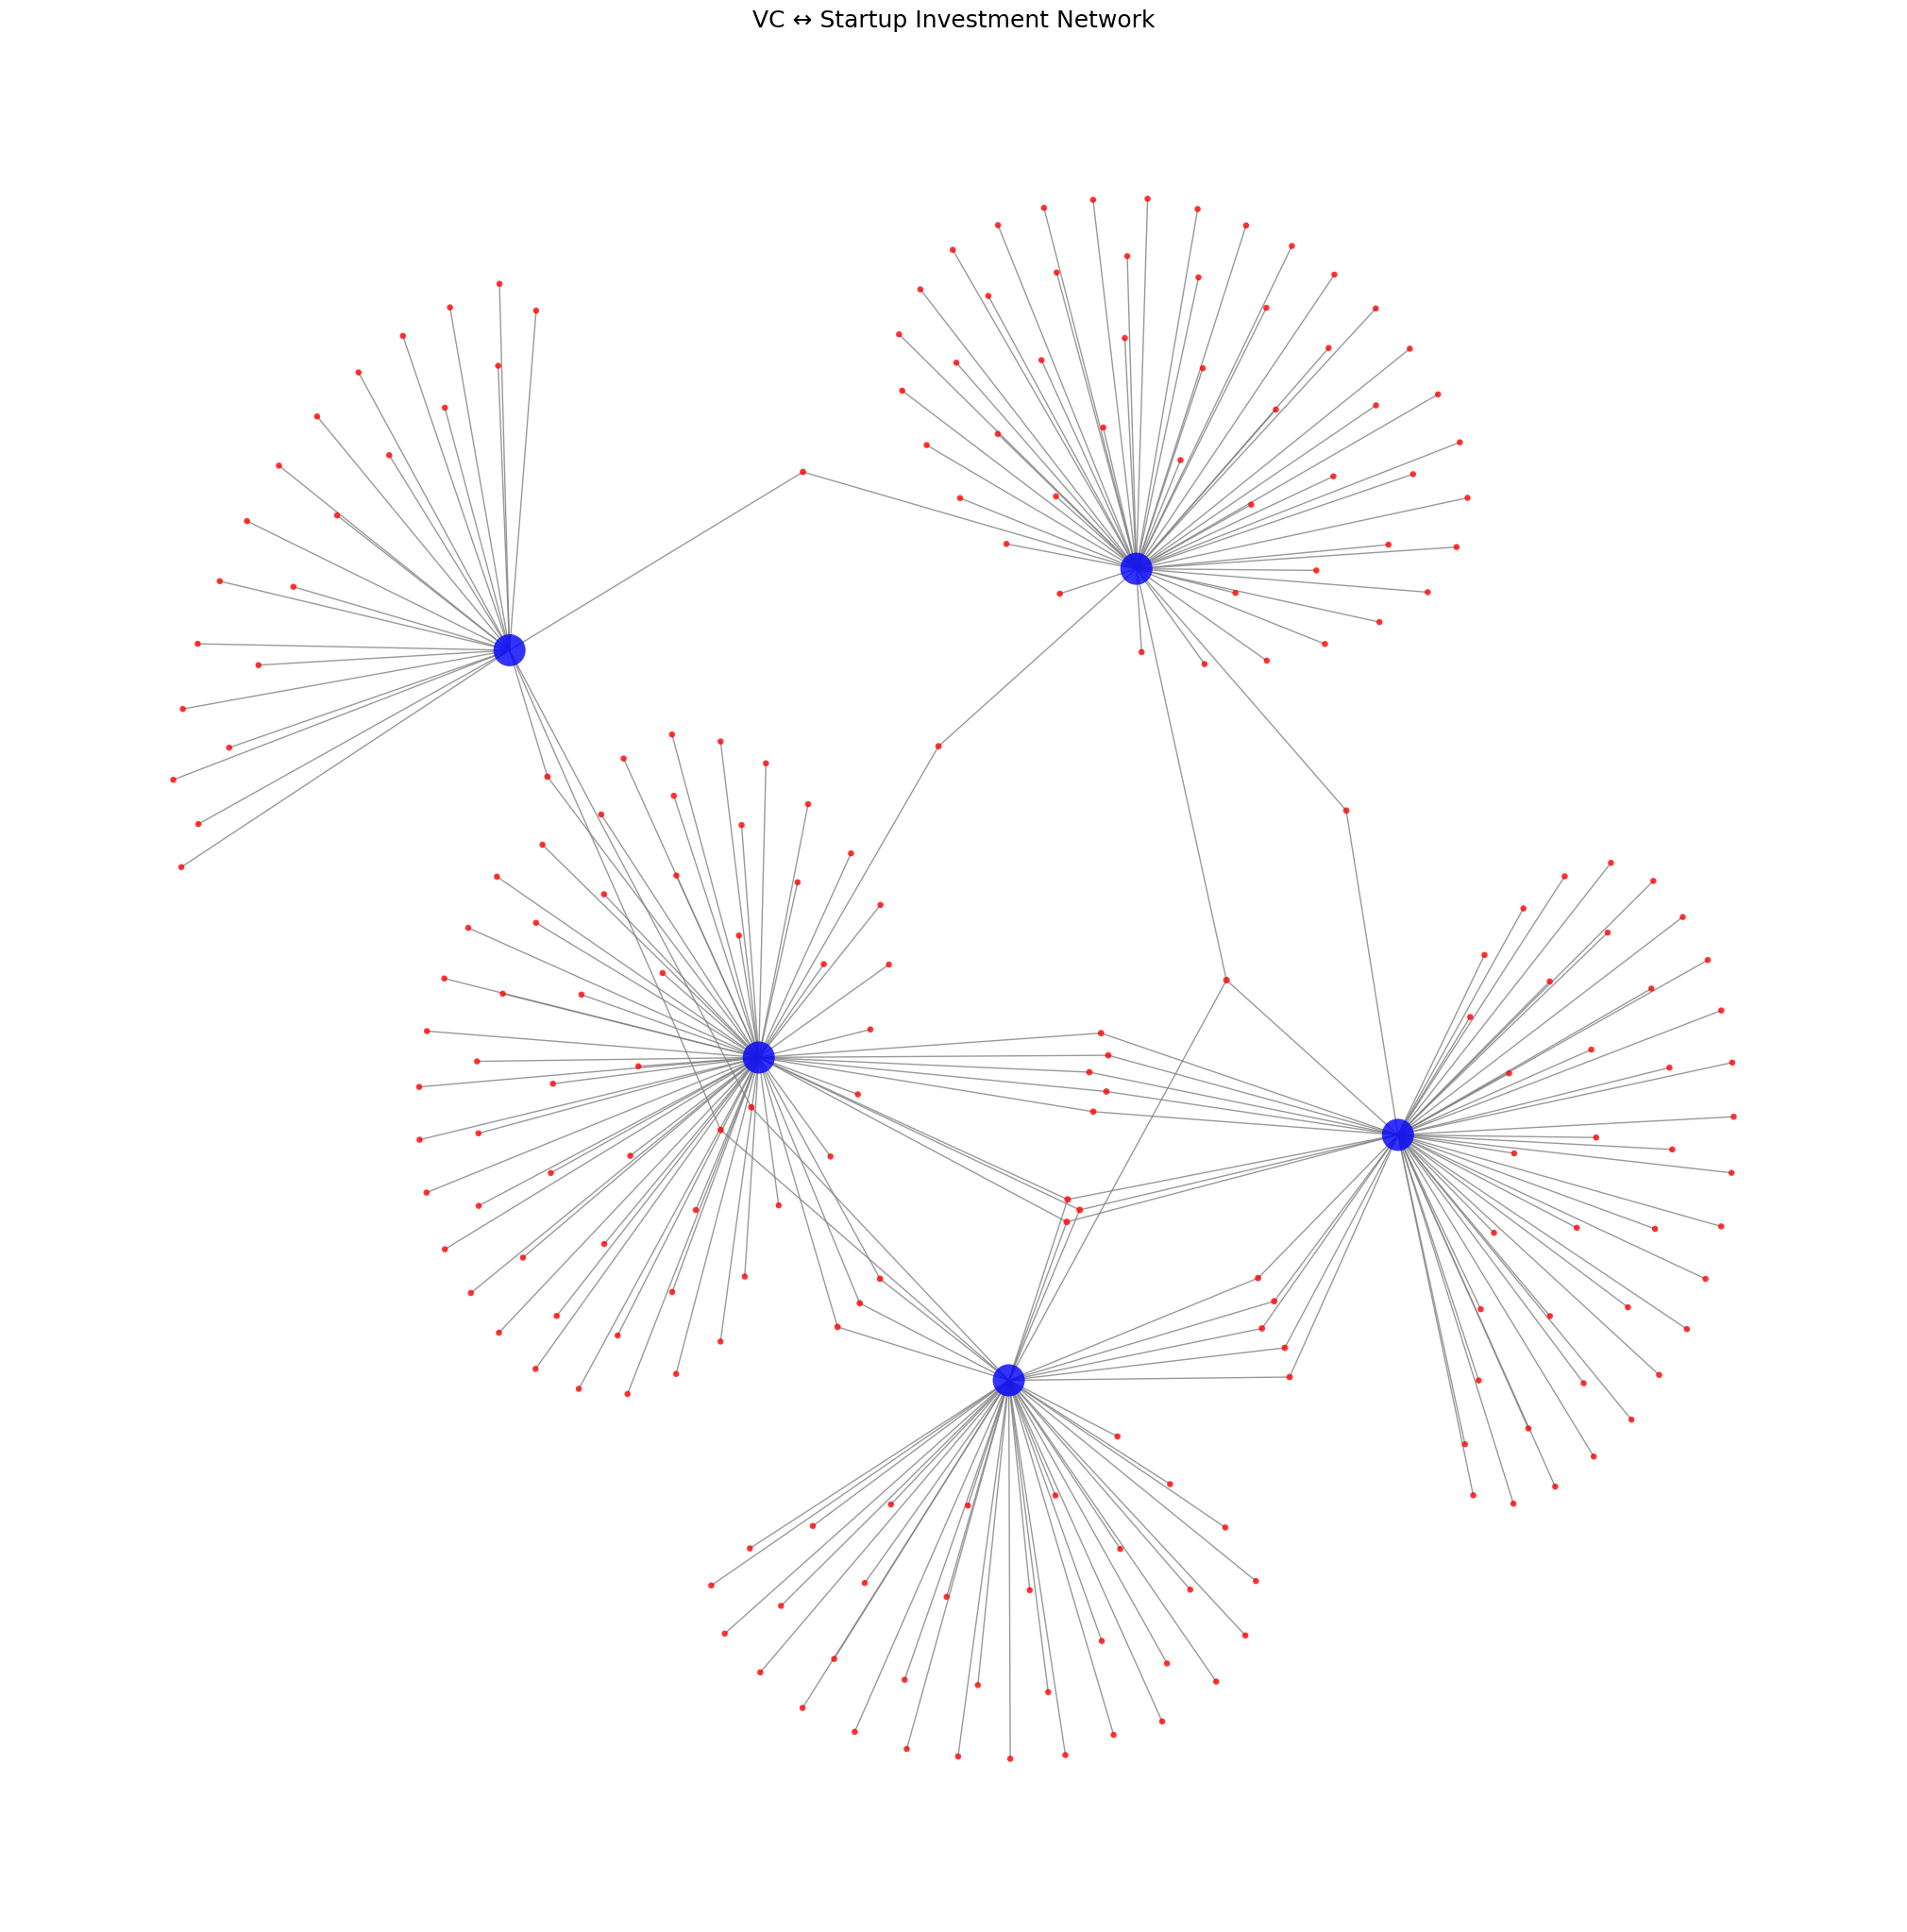

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt




# ────────────────────────────────
# 1.  Load your data
# ────────────────────────────────
df = pd.read_csv("Combined VC Data - Sheet1.csv")

# ────────────────────────────────
# 2.  Build the node lists
# ────────────────────────────────
nodes_investors = df["vc_name"].unique().tolist()
nodes_startups  = df["company_name"].unique().tolist()


G = nx.Graph()
G.add_nodes_from(nodes_investors,  type="investor")
G.add_nodes_from(nodes_startups,   type="startup")


edges = list(df[["vc_name", "company_name"]].itertuples(index=False, name=None))
G.add_edges_from(edges)

plt.figure(figsize=(20, 20))

colors = ["blue" if G.nodes[n]["type"] == "investor" else "red"
          for n in G.nodes]

sizes  = [600  if G.nodes[n]["type"] == "investor"
          else 20 + 2*G.degree(n)
          for n in G.nodes]

pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos,
        node_color=colors,
        node_size=sizes,
        edge_color="gray",
        alpha=0.8,
        linewidths=0,
        with_labels=False)

plt.title("VC ↔ Startup Investment Network", fontsize=18)
plt.axis("off")
plt.tight_layout()
plt.show()

✅ Data loaded: 249 rows, 10 cols


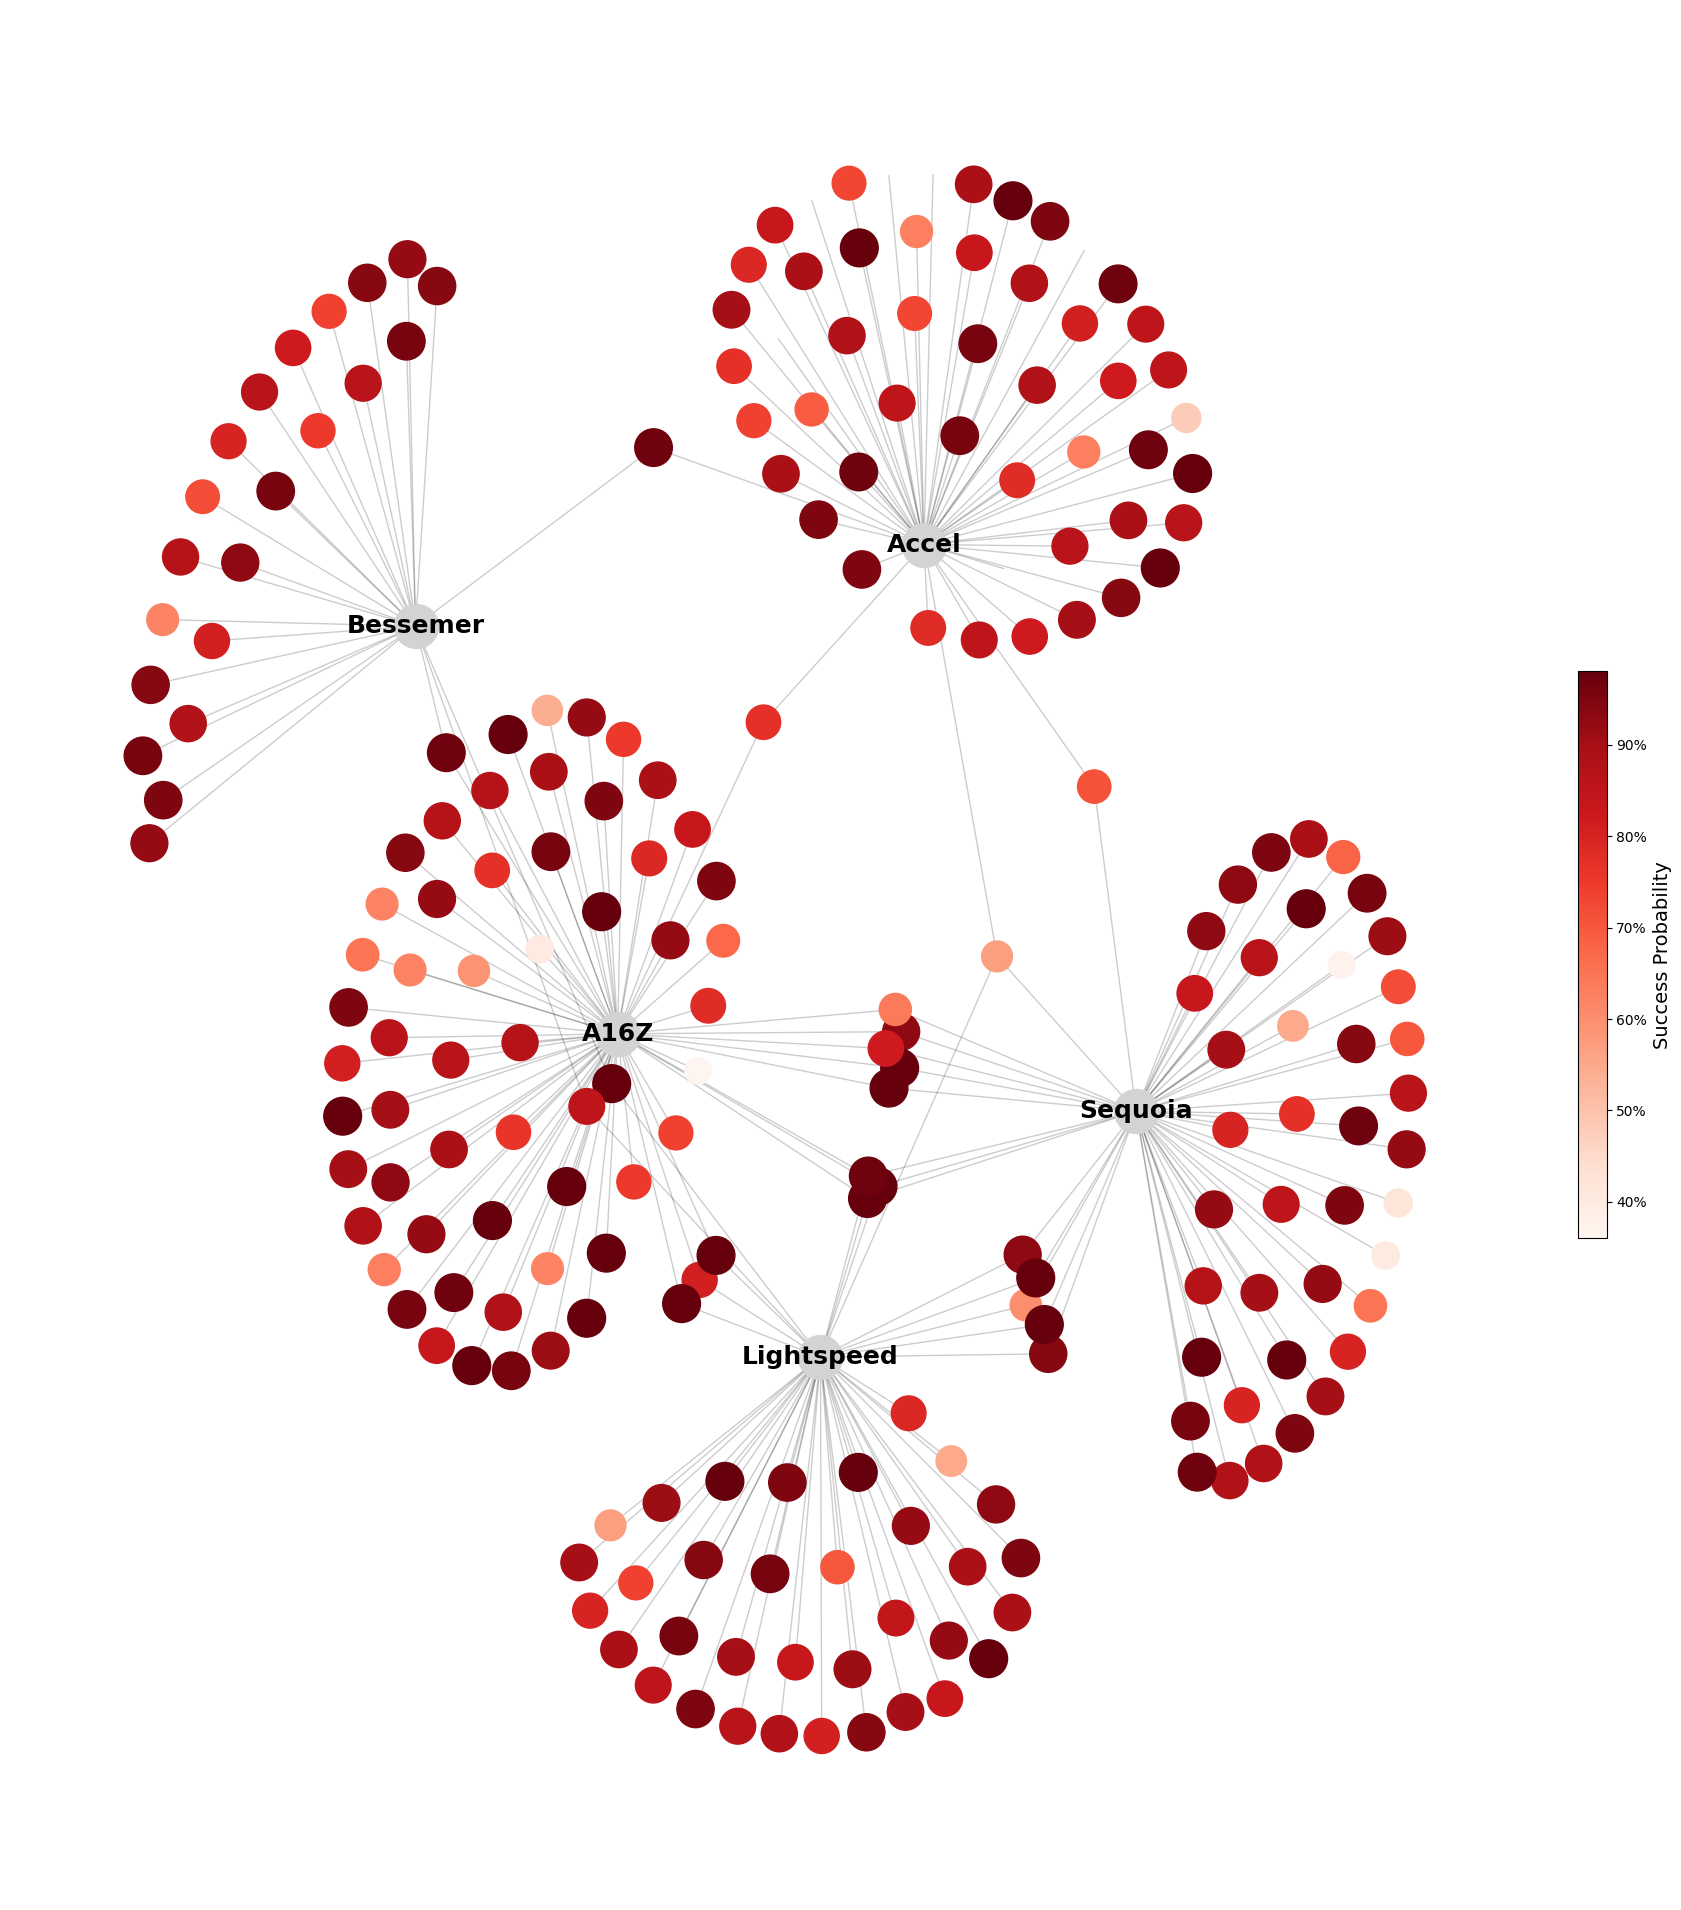

In [ ]:
# ▶️ Full updated network‐plot cell with bold VC labels & percentage legend

import os
import pandas as pd

# ——— 1. Load CSV once ———
fname = 'Combined VC Data - Sheet1.csv'
if not os.path.exists(fname):
    from google.colab import files
    uploaded = files.upload()                      # only pops up if file not present
    import io
    key = list(uploaded.keys())[0]
    with open(fname, 'wb') as f:
        f.write(uploaded[key])

df = pd.read_csv(fname)
print(f"✅ Data loaded: {df.shape[0]} rows, {df.shape[1]} cols")

# ——— 2. Nodes & edges ———
nodes_investors = df['vc_name'].unique().tolist()
nodes_startups  = df['company_name'].unique().tolist()
list_edges      = list(df[['vc_name','company_name']].itertuples(index=False, name=None))

# ——— 3. Parse success_probability as floats (0–1) ———
prob = (
    df[['company_name','success_probability']]
     .drop_duplicates()
     .assign(success_probability=lambda d: d['success_probability']
                                               .str.rstrip('%').astype(float)/100)
     .set_index('company_name')['success_probability']
     .to_dict()
)

# ——— 4. Build graph ———
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes_investors, type='investor')
G.add_nodes_from(nodes_startups,  type='startup')
G.add_edges_from(list_edges)

# ——— 5. Layout ———
pos = nx.kamada_kawai_layout(G)

# ——— 6. Styling parameters ———
import matplotlib.pyplot as plt
import matplotlib as mpl

# Colormap & normalization
cmap = plt.cm.Reds
norm = mpl.colors.Normalize(vmin=min(prob.values()), vmax=max(prob.values()))

# Node colors & sizes
investor_color = 'lightgrey'
investor_size  = 1000

startup_colors = [cmap(norm(prob[n]))                  for n in nodes_startups]
startup_sizes  = [(300 + 1200 * prob[n]) * 0.5         for n in nodes_startups]  # half scale

# ——— 7. Draw ———
fig, ax = plt.subplots(figsize=(20,20))

nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax)

nx.draw_networkx_nodes(G, pos,
    nodelist=nodes_investors,
    node_color=investor_color,
    node_size=investor_size,
    ax=ax
)

nx.draw_networkx_nodes(G, pos,
    nodelist=nodes_startups,
    node_color=startup_colors,
    node_size=startup_sizes,
    ax=ax
)

# Bold, larger VC labels
nx.draw_networkx_labels(G, pos,
    labels={n:n for n in nodes_investors},
    font_color='black',
    font_size=18,
    font_weight='bold',
    ax=ax
)

# ——— 8. Smaller legend in top‐right with percentage ticks ———
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, shrink=0.3, pad=0.02)
cbar.ax.set_position([0.92, 0.72, 0.02, 0.2])
cbar.set_label('Success Probability', size=14)

# Format tick labels as percentages
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

# ——— 9. Cleanup ———
ax.set_axis_off()
plt.tight_layout()
plt.show()


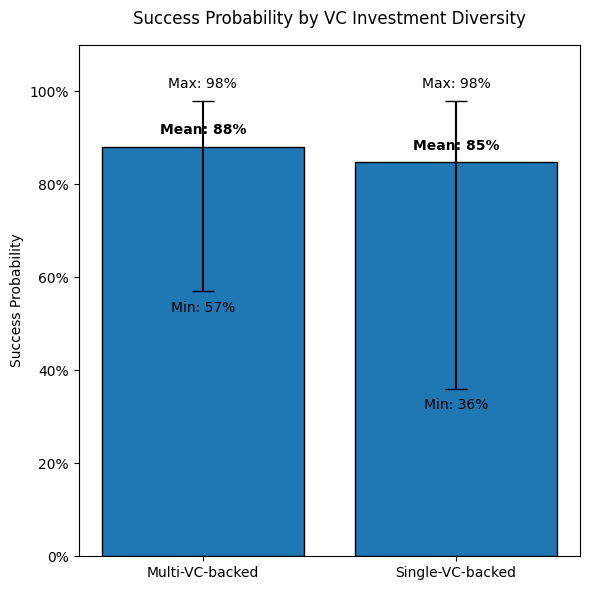

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# 1. Ensure success_probability is numeric 0–1
df['success_frac'] = (
    df['success_probability']
      .str.rstrip('%')
      .astype(float)
      .div(100)
)

# 2. Count how many distinct VCs invested in each startup
vc_counts = df.groupby('company_name')['vc_name'] \
              .nunique() \
              .rename('vc_count')

# 3. Build summary DataFrame and label groups
summary = pd.DataFrame({
    'success_frac': df.groupby('company_name')['success_frac'].first(),
    'vc_count': vc_counts
})
summary['group'] = summary['vc_count'].apply(
    lambda x: 'Multi-VC-backed' if x > 1 else 'Single-VC-backed'
)

# 4. Compute min, mean, max for each group
stats = summary.groupby('group')['success_frac'] \
               .agg(['min', 'mean', 'max'])

# 5. Plot mean ± min/max with annotations
fig, ax = plt.subplots(figsize=(6, 6))
groups = stats.index
means  = stats['mean']
mins   = stats['min']
maxs   = stats['max']
yerr   = [means - mins, maxs - means]

bars = ax.bar(groups, means, yerr=yerr,
              capsize=8, edgecolor='black')

# Annotate actual numbers
for idx, grp in enumerate(groups):
    ax.text(idx, means[grp] + 0.02,
            f'Mean: {means[grp]:.0%}',
            ha='center', va='bottom', fontweight='bold')
    ax.text(idx, mins[grp] - 0.02,
            f'Min: {mins[grp]:.0%}',
            ha='center', va='top')
    ax.text(idx, maxs[grp] + 0.02,
            f'Max: {maxs[grp]:.0%}',
            ha='center', va='bottom')

# Formatting
ax.set_title('Success Probability by VC Investment Diversity', pad=15)
ax.set_ylabel('Success Probability')
ax.set_ylim(0, 1.1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.tight_layout()
plt.show()


✅ Data loaded: 249 rows, 10 cols


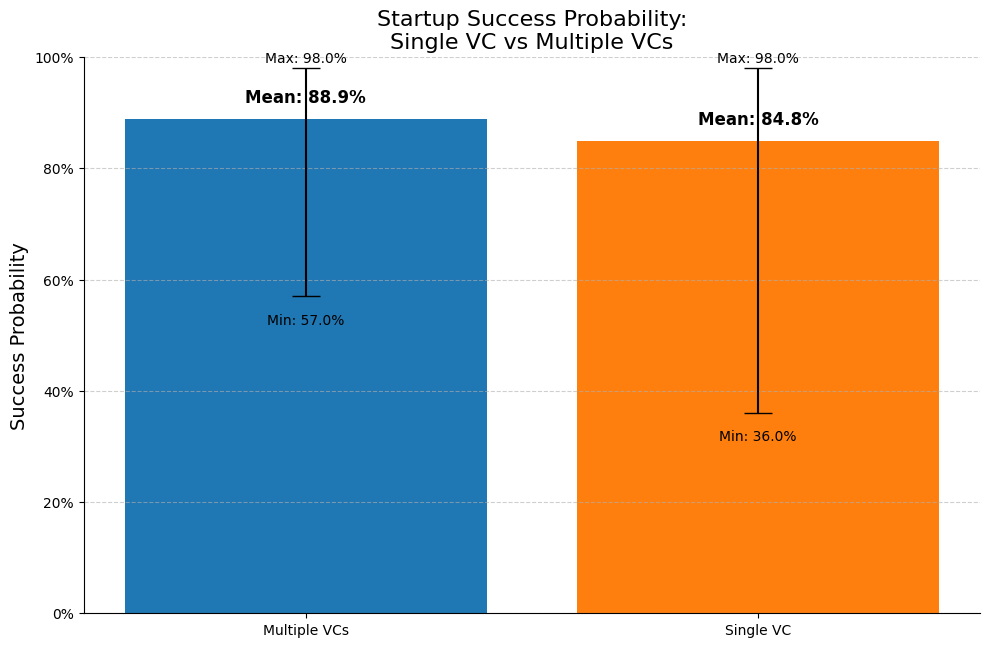

In [ ]:
# Clean success_probability
fname = 'Combined VC Data - Sheet1.csv'
if not os.path.exists(fname):
    from google.colab import files
    uploaded = files.upload()                      # only pops up if file not present
    import io
    key = list(uploaded.keys())[0]
    with open(fname, 'wb') as f:
        f.write(uploaded[key])

df = pd.read_csv(fname)
print(f"✅ Data loaded: {df.shape[0]} rows, {df.shape[1]} cols")

df['success_probability'] = df['success_probability'].str.rstrip('%').astype(float) / 100

# Count VCs per startup
startup_vc_counts = df.groupby('company_name')['vc_name'].nunique().reset_index(name='num_vcs')
df = df.merge(startup_vc_counts, on='company_name')
df['vc_type'] = df['num_vcs'].apply(lambda x: 'Single VC' if x == 1 else 'Multiple VCs')

# Deduplicate startups
startup_success = df[['company_name', 'success_probability', 'vc_type']].drop_duplicates()

# Group stats
group_stats = (
    startup_success.groupby('vc_type')['success_probability']
    .agg(['mean', 'min', 'max'])
    .reset_index()
)

# Extract for plotting
labels = group_stats['vc_type']
means = group_stats['mean']
mins = group_stats['min']
maxs = group_stats['max']
errors = [means - mins, maxs - means]

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(labels, means, yerr=errors, capsize=10, color=['#1f77b4', '#ff7f0e'])

# Add mean, min, and max text annotations
for i, (mean, minv, maxv) in enumerate(zip(means, mins, maxs)):
    ax.text(i, mean + 0.03, f"Mean: {mean:.1%}", ha='center', fontsize=12, fontweight='bold', color='black')
    ax.text(i, minv - 0.05, f"Min: {minv:.1%}", ha='center', fontsize=10, color='black')
    ax.text(i, maxv + 0.01, f"Max: {maxv:.1%}", ha='center', fontsize=10, color='black')

# Final touches
ax.set_ylim(0, 1)
ax.set_ylabel('Success Probability', fontsize=14)
ax.set_title('Startup Success Probability:\nSingle VC vs Multiple VCs', fontsize=16)
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1))
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(top=0.85)

plt.show()

Saving Combined VC Data - Sheet1.csv to Combined VC Data - Sheet1.csv
✅ Data loaded: 249 rows, 10 cols


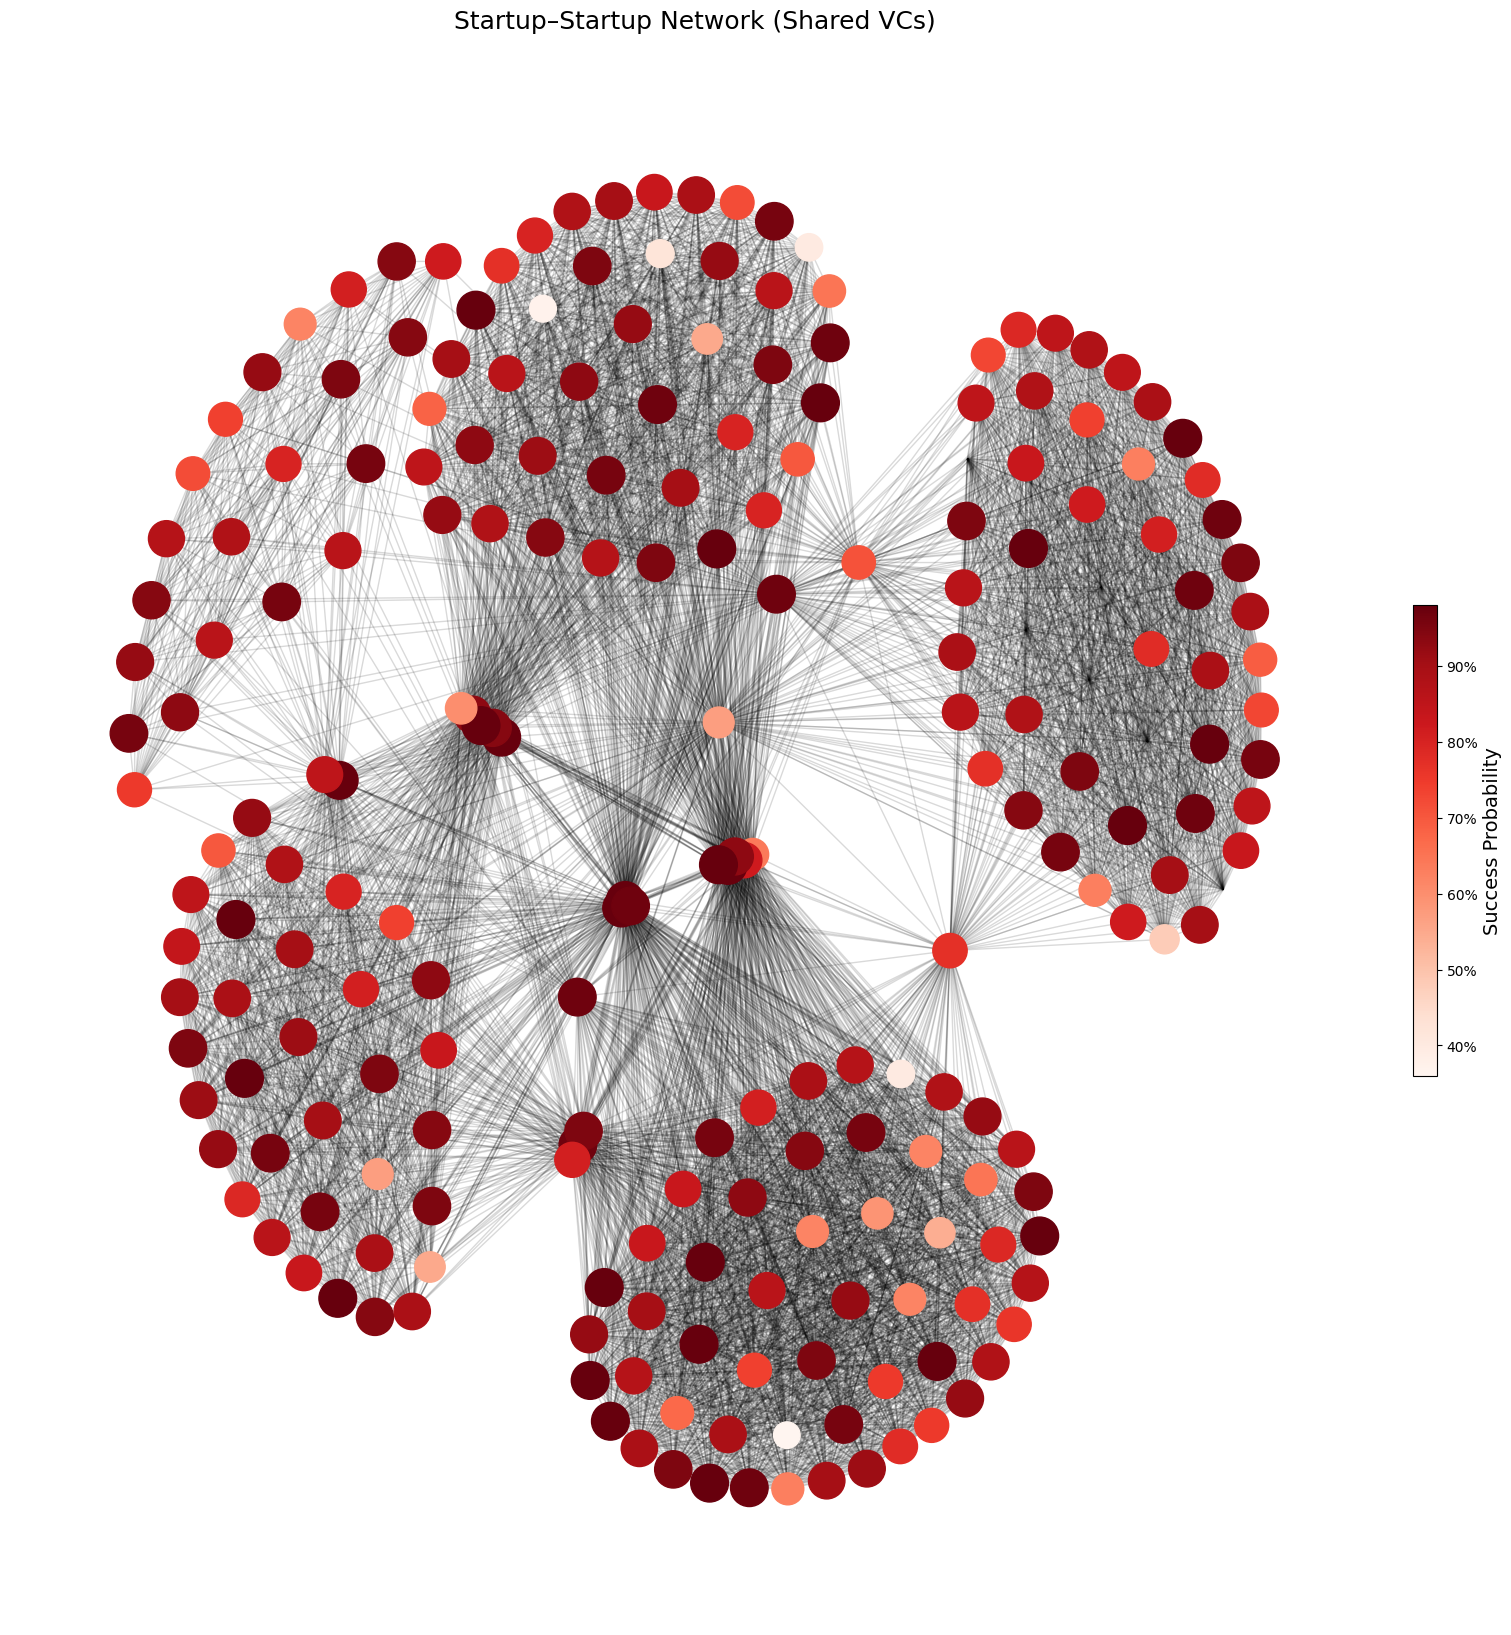

╒══════════════════════════════════════════════╤══════════╤═══════════════════════════╤════════════════════════════════════╕
│ Startup                                      │   Degree │ Own Success Probability   │ Avg Neighbor Success Probability   │
╞══════════════════════════════════════════════╪══════════╪═══════════════════════════╪════════════════════════════════════╡
│ Safe Superintelligence                       │      149 │ 98.00%                    │ 84.82%                             │
├──────────────────────────────────────────────┼──────────┼───────────────────────────┼────────────────────────────────────┤
│ Wiz (Network Management Software)            │      149 │ 98.00%                    │ 84.82%                             │
├──────────────────────────────────────────────┼──────────┼───────────────────────────┼────────────────────────────────────┤
│ Saronic Technologies                         │      149 │ 97.00%                    │ 84.83%                             │


In [ ]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import os
import matplotlib.pyplot as plt
import matplotlib as mpl


# Load your data
fname = 'Combined VC Data - Sheet1.csv'
if not os.path.exists(fname):
    from google.colab import files
    uploaded = files.upload()                      # only pops up if file not present
    import io
    key = list(uploaded.keys())[0]
    with open(fname, 'wb') as f:
        f.write(uploaded[key])

df = pd.read_csv(fname)
print(f"✅ Data loaded: {df.shape[0]} rows, {df.shape[1]} cols")

df['success_probability'] = df['success_probability'].str.rstrip('%').astype(float) / 100

# Define sets
startups = set(df['company_name'])
vcs = set(df['vc_name'])

# Build clean bipartite graph
B = nx.Graph()
B.add_nodes_from(startups, bipartite='startups')
B.add_nodes_from(vcs, bipartite='vcs')
B.add_edges_from(df[['company_name', 'vc_name']].values)

# Fresh startup-startup projection
G_proj = nx.bipartite.weighted_projected_graph(B, startups)


G_proj = nx.bipartite.weighted_projected_graph(B, startups)

# ——— 3. Attach success probabilities ———
success_prob = df.drop_duplicates('company_name').set_index('company_name')['success_probability'].to_dict()
nx.set_node_attributes(G_proj, success_prob, name='success_probability')

# ——— 4. Layout ———
pos = nx.kamada_kawai_layout(G_proj)

# ——— 5. Style: Colors and Sizes ———
cmap = plt.cm.Reds
norm = mpl.colors.Normalize(vmin=min(success_prob.values()), vmax=max(success_prob.values()))

node_colors = [cmap(norm(success_prob[n])) for n in G_proj.nodes]
node_sizes = [(300 + 1200 * success_prob[n]) * 0.5 for n in G_proj.nodes]

# ——— 6. Draw network ———
fig, ax = plt.subplots(figsize=(18, 18))

nx.draw_networkx_edges(G_proj, pos, alpha=0.15, ax=ax)

nx.draw_networkx_nodes(G_proj, pos,
    node_color=node_colors,
    node_size=node_sizes,
    ax=ax
)

# ——— 7. Add color legend (success probability) ———
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, shrink=0.3, pad=0.02)
cbar.ax.set_position([0.92, 0.72, 0.02, 0.2])
cbar.set_label('Success Probability', size=14)
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

# ——— 8. Final cleanup ———
ax.set_title("Startup–Startup Network (Shared VCs)", fontsize=18, pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()



# ——— Create analysis table ———
from tabulate import tabulate
import numpy as np

# Build startup-level stats before formatting
startup_data = []
for node in G_proj.nodes:
    degree = G_proj.degree[node]
    neighbors = list(G_proj.neighbors(node))

    # Only include neighbors with known success prob
    neighbor_probs = [success_prob[n] for n in neighbors if n in success_prob and pd.notna(success_prob[n])]

    avg_neighbor_success = (
        sum(neighbor_probs) / len(neighbor_probs) if neighbor_probs else None
    )

    startup_data.append({
        'startup': node,
        'degree': degree,
        'own_success_prob': success_prob.get(node, None),
        'avg_neighbor_success_prob': avg_neighbor_success
    })


startup_df = pd.DataFrame(startup_data)

# Select top 10 startups by degree
top10 = startup_df.sort_values('degree', ascending=False).head(10)


# Step 1: Format success probability values BEFORE renaming
top10['own_success_prob'] = top10['own_success_prob'].apply(
    lambda val: f"{val * 100:.2f}%" if pd.notna(val) else "N/A"
)
top10['avg_neighbor_success_prob'] = top10['avg_neighbor_success_prob'].apply(
    lambda val: f"{val * 100:.2f}%" if pd.notna(val) else "N/A"
)

# Step 2: Save original startup names for debugging before renaming
startup_names = top10['startup'].tolist()

# Step 3: Rename columns for display
top10.columns = ['Startup', 'Degree', 'Own Success Probability', 'Avg Neighbor Success Probability']

# Step 4: Print pretty table
print(tabulate(top10, headers='keys', tablefmt='fancy_grid', showindex=False))

# Step 5: Debug: Check consistency of degree and neighbor list
for node in startup_names:
    deg = G_proj.degree[node]
    neighbors = list(G_proj.neighbors(node))
    print(f"{node} — Degree: {deg}, Neighbors: {neighbors}, Neighbor count: {len(neighbors)}")



